# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
!pwd

/Users/azizmamatov/Google_Drive


In [102]:
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline

# read in the json files
portfolio = pd.read_json('/Users/azizmamatov/Downloads/portfolio.json', orient='records', lines=True)
profile = pd.read_json('/Users/azizmamatov/Downloads/profile.json', orient='records', lines=True)
transcript = pd.read_json('/Users/azizmamatov/Downloads/transcript.json', orient='records', lines=True)

In [103]:
# ignore warning notes as they negatively affect the presenation
import warnings; warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
%matplotlib inline

In [104]:
from catboost import CatBoostClassifier

In [105]:
pd.set_option('display.width', 1000000000)
pd.set_option('max_colwidth', 500000)
pd.set_option("display.max_columns", 101)

Portfolio data frame has description of the offers and can be joined with transactions data

In [8]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [9]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [10]:
portfolio.shape

(10, 6)

I need to create dummy variables from the list of strings in columns channels

In [11]:
pd.get_dummies(pd.DataFrame(portfolio['channels'].tolist()).stack(). \
               reset_index(level=1, drop=True)).groupby(level=0).sum()

,email,mobile,social,web
0,1,1,1,0
1,1,1,1,1
2,1,1,0,1
3,1,1,0,1
4,1,0,0,1
5,1,1,1,1
6,1,1,1,1
7,1,1,1,0
8,1,1,1,1
9,1,1,0,1


In [106]:
portfolio = pd.concat([portfolio, pd.get_dummies(pd.DataFrame(portfolio['channels'].tolist()).stack(). \
               reset_index(level=1, drop=True)).groupby(level=0).sum()], axis=1)
portfolio.drop(columns='channels', inplace=True)

In [107]:
portfolio.head()

,difficulty,duration,id,offer_type,reward,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1


### Profile data 
- 17K customers with missing data for Income, gender and inaccurate information on age;
- 2.1K of customers have no real age, income or gender
- We will separate them into special category and deal with data

In [14]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [15]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [108]:
profile['became_member_on']=pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

Text(0, 0.5, 'Count of users')

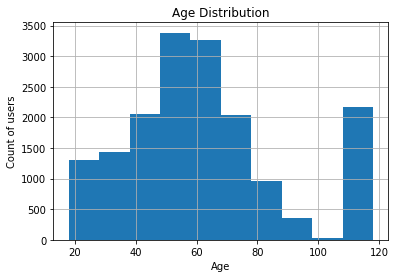

In [109]:
# Large chunk of data is clearly incorrect, as the age close to 100 and over it. Need to replace it with the average
profile['age'].hist()
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count of users')


#### Data with missing income: all age is 118, which is non-senscial and is a candidate to be filtered out. Age 118 income is null and also their gender is None. 


In [18]:
profile[profile['income'].isnull()].head()


,age,became_member_on,gender,id,income
0,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,2017-09-25,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,2017-10-02,None,68617ca6246f4fbc85e91a2a49552598,NaN


In [19]:
profile['gender'][profile['income'].isnull()].value_counts(dropna=False)

NaN    2175
Name: gender, dtype: int64

All income null users are aged 118

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1327a3748>,
      dtype=object)

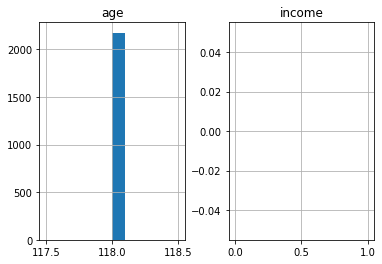

In [112]:
profile[profile['income'].isnull()].hist()



All age 118 have income of null

In [21]:
np.sum(profile[profile['age']==118].index != profile[profile['income'].isnull()].index)

0

All age 118 have nan gender

In [22]:
profile['gender'][profile['age']==118].value_counts(dropna=False)

NaN    2175
Name: gender, dtype: int64

Where gender is None, there are different age groups

Text(0, 0.5, 'Count')

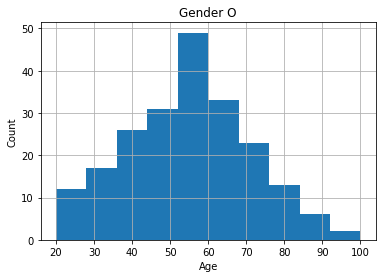

In [113]:
profile['age'][profile['gender']=='O'].hist()
# & (profile['age']==118)
plt.title('Gender O')
plt.xlabel('Age')
plt.ylabel('Count')


In [24]:
profile['age']=profile['age'].replace({118:np.nan})

Lets keep the persons with 118 age as there are quite few of them and they comprise a demographic group which potentially can be lucrative for targeting. We don't know at this stage whether they are lucrative target or not

In [25]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [92]:
#transcript[transcript['time']<168].groupby(['person','event']).size().sort_values(ascending=False)

In [26]:
pd.set_option('max_colwidth', 500000)
transcript.groupby('event').apply(lambda x: x.iloc[:10]['value'])

event                 
offer completed  12658     {'offer_id': '2906b810c7d4411798c6938adc9daaa5', 'reward': 2}
                 12672     {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2}
                 12679     {'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'reward': 5}
                 12692    {'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd', 'reward': 10}
                 12697    {'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0', 'reward': 10}
                 12717    {'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0', 'reward': 10}
                 12721     {'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2', 'reward': 3}
                 12744     {'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d', 'reward': 5}
                 12764     {'offer_id': '2906b810c7d4411798c6938adc9daaa5', 'reward': 2}
                 12767    {'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0', 'reward': 10}
offer received   0                      {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'

In [27]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


Time is distributed not normally according to below histogram.

Text(0, 0.5, 'Count')

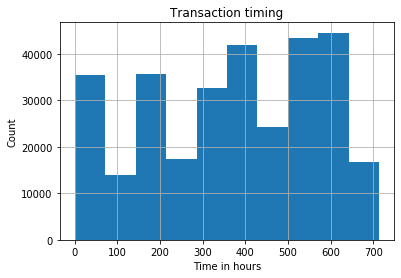

In [114]:
transcript.hist()
plt.title('Transaction timing')
plt.xlabel('Time in hours')
plt.ylabel('Count')

There are users who received the offer but never viewed it or completed it. And All of the users have some kind of transaction for them

Text(0.5, 1.0, 'Event types')

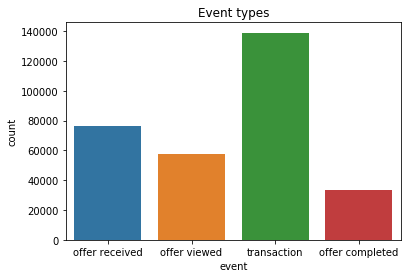

In [115]:
sns.countplot(transcript['event'])
plt.title('Event types')



Majority of the users received 5 and 6 offers

Text(0, 0.5, 'Counts')

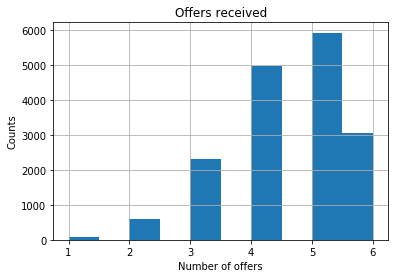

In [116]:
transcript[transcript['event']=="offer received"]['person'].value_counts().hist()
plt.title('Offers received')
plt.xlabel('Number of offers')
plt.ylabel('Counts')


Distribution of the users by the count of any event (count time). Majority of the users had <10 transactions while there are few who made 35 transactions

Text(0, 0.5, 'Count')

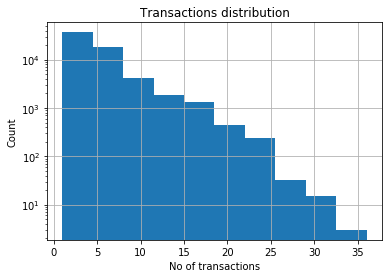

In [117]:
transcript.groupby(['person', 'event']).count()['time'].hist(log=True)
plt.title('Transactions distribution')
plt.xlabel('No of transactions')
plt.ylabel('Count')


Review of users' sample behavior: By looking at minimum time for each event we see that they usually receive the offer then view it, then complete it and transaction can be before or after the offer 

In [32]:
transcript.groupby(['person', 'event']).min()['time']

person                            event          
0009655768c64bdeb2e877511632db8f  offer completed    414
                                  offer received     168
                                  offer viewed       192
                                  transaction        228
00116118485d4dfda04fdbaba9a87b5c  offer received     168
                                  offer viewed       216
                                  transaction        294
0011e0d4e6b944f998e987f904e8c1e5  offer completed    252
                                  offer received       0
                                  offer viewed         6
                                  transaction        132
0020c2b971eb4e9188eac86d93036a77  offer completed     54
                                  offer received       0
                                  offer viewed        12
                                  transaction         54
0020ccbbb6d84e358d3414a3ff76cffd  offer completed    222
                                  offe

From the above we can see that when the users received the offer and there are six times in the testing period

In [33]:
transcript['time'][transcript['event']=='offer received'].value_counts()

408    12778
576    12765
336    12711
504    12704
168    12669
0      12650
Name: time, dtype: int64

There are users who made all four types of events

In [34]:
transcript.groupby(['person', 'event']).count()['time'].sort_index(level=0).head()

person                            event          
0009655768c64bdeb2e877511632db8f  offer completed    3
                                  offer received     5
                                  offer viewed       4
                                  transaction        8
00116118485d4dfda04fdbaba9a87b5c  offer received     2
Name: time, dtype: int64

There are users who made maximum transactions: 36 

In [35]:
transcript[transcript['event']=="transaction"]['person'].value_counts().head()

79d9d4f86aca4bed9290350fb43817c2    36
8dbfa485249f409aa223a2130f40634a    36
94de646f7b6041228ca7dec82adb97d2    35
b1f4ece7d49342628a9ed77aee2cde58    32
5e60c6aa3b834e44b822ea43a3efea26    32
Name: person, dtype: int64

There are 422 customers who don't have any 'transaction' event but have other events: offer received and offer viewed. As such the absolute majority of the users have 'transaction' event, where they actually purchase something

In [36]:
transcript['person'][~transcript['person'].isin(transcript[transcript['event']=="transaction"]['person'])].nunique()

422

In [37]:
cust_no_transactions=transcript['person'][~transcript['person'].isin(transcript[transcript['event']=="transaction"]\
                                                                     ['person'])].unique()

Text(0.5, 1.0, 'Offers distribution')

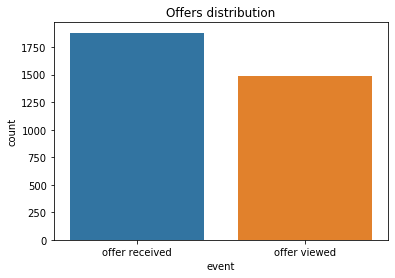

In [118]:
sns.countplot(transcript['event'][transcript['person'].isin(cust_no_transactions)])
plt.title('Offers distribution')



In [39]:
transcript['value'].value_counts()

{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}                  14983
{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}                  14924
{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}                  14891
{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}                  14835
{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}                  14374
{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}                  14305
{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}                  11848
{'offer id': '3f207df678b143eea3cee63160fa8bed'}                  11761
{'offer id': '2906b810c7d4411798c6938adc9daaa5'}                  11750
{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}                  10331
{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2}      5317
{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2', 'reward': 3}      5156
{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'reward': 5}      4354
{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d', 'reward': 5}   

In [40]:
portfolio['offer_type'][portfolio['id']=='5a8bc65990b245e5a138643cd4eb9837']

7    informational
Name: offer_type, dtype: object

#### We can see that in the dictionary, there is a different spelling of 'offer_id'! It is also spelled as 'offer id'!

In [41]:
#checking one of the users who received different offers and made transactions
transcript[transcript['person']=='948ec827ac334c8782a1da99a2d6a39b']

,event,person,time,value
6411,offer received,948ec827ac334c8782a1da99a2d6a39b,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
21307,offer viewed,948ec827ac334c8782a1da99a2d6a39b,18,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
21308,transaction,948ec827ac334c8782a1da99a2d6a39b,18,{'amount': 8.18}
28735,transaction,948ec827ac334c8782a1da99a2d6a39b,42,{'amount': 13.14}
28736,offer completed,948ec827ac334c8782a1da99a2d6a39b,42,"{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd', 'reward': 10}"
31878,transaction,948ec827ac334c8782a1da99a2d6a39b,54,{'amount': 7.58}
59615,offer received,948ec827ac334c8782a1da99a2d6a39b,168,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
67664,offer viewed,948ec827ac334c8782a1da99a2d6a39b,168,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
73552,transaction,948ec827ac334c8782a1da99a2d6a39b,180,{'amount': 9.65}
88036,transaction,948ec827ac334c8782a1da99a2d6a39b,222,{'amount': 10.25}


In [42]:
#lets correct the above formula, as the offer id is spelled differently
transcript['offer_id']=transcript['value'].map(lambda x: x.get('offer_id', x.get('offer id', '')))

In [43]:
transcript[transcript['person']=='948ec827ac334c8782a1da99a2d6a39b'].head()

,event,person,time,value,offer_id
6411,offer received,948ec827ac334c8782a1da99a2d6a39b,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},ae264e3637204a6fb9bb56bc8210ddfd
21307,offer viewed,948ec827ac334c8782a1da99a2d6a39b,18,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},ae264e3637204a6fb9bb56bc8210ddfd
21308,transaction,948ec827ac334c8782a1da99a2d6a39b,18,{'amount': 8.18},
28735,transaction,948ec827ac334c8782a1da99a2d6a39b,42,{'amount': 13.14},
28736,offer completed,948ec827ac334c8782a1da99a2d6a39b,42,"{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd', 'reward': 10}",ae264e3637204a6fb9bb56bc8210ddfd


In [44]:
transcript_p =transcript.merge(portfolio, how ="left", left_on='offer_id', right_on='id')

In [45]:
#lets see offers ids with empty cells
transcript_p[transcript_p['offer_id']!=''].groupby(['offer_id','person']).size().sort_values(ascending=False)

offer_id                          person                          
fafdcd668e3743c1bb461111dcafc2a4  2ea50de315514ccaa5079db4c1ecbc0b    13
ae264e3637204a6fb9bb56bc8210ddfd  948ec827ac334c8782a1da99a2d6a39b    12
                                  d3209835a40a423fbf2c967218d00bcd    12
2906b810c7d4411798c6938adc9daaa5  61f661b7070c4063880a85b22f1fe0e4    12
ae264e3637204a6fb9bb56bc8210ddfd  db23badcb0e64c0eb193721a727a446f    12
4d5c57ea9a6940dd891ad53e9dbe8da0  c93f9619abd642a684bd79953cef992c    12
f19421c1d4aa40978ebb69ca19b0e20d  6d2db3aad94648259e539920fc2cf2a6    12
2906b810c7d4411798c6938adc9daaa5  ac3b8c9879304a9db841fa510d931ea7    12
2298d6c36e964ae4a3e7e9706d1fb8c2  2dab8c385a2440b78b432ecb72d68787    12
                                  ea54840ba8a54a098de60d39fc533d51    12
9b98b8c7a33c4b65b9aebfe6a799e6d9  e7757d0a16384143ad9b2f9e429c23a9    12
4d5c57ea9a6940dd891ad53e9dbe8da0  ad84e9ec3c33444c859e0295773bc05f    12
9b98b8c7a33c4b65b9aebfe6a799e6d9  4b72995c52ab4cd5ab40792

In [46]:
#lets see another person 
transcript_p[transcript_p['person']=='948ec827ac334c8782a1da99a2d6a39b']

,event,person,time,value,offer_id,difficulty,duration,id,offer_type,reward,email,mobile,social,web
6411,offer received,948ec827ac334c8782a1da99a2d6a39b,0,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},ae264e3637204a6fb9bb56bc8210ddfd,10.0,7.0,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10.0,1.0,1.0,1.0,0.0
21307,offer viewed,948ec827ac334c8782a1da99a2d6a39b,18,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},ae264e3637204a6fb9bb56bc8210ddfd,10.0,7.0,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10.0,1.0,1.0,1.0,0.0
21308,transaction,948ec827ac334c8782a1da99a2d6a39b,18,{'amount': 8.18},,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28735,transaction,948ec827ac334c8782a1da99a2d6a39b,42,{'amount': 13.14},,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28736,offer completed,948ec827ac334c8782a1da99a2d6a39b,42,"{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd', 'reward': 10}",ae264e3637204a6fb9bb56bc8210ddfd,10.0,7.0,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10.0,1.0,1.0,1.0,0.0
31878,transaction,948ec827ac334c8782a1da99a2d6a39b,54,{'amount': 7.58},,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
59615,offer received,948ec827ac334c8782a1da99a2d6a39b,168,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},ae264e3637204a6fb9bb56bc8210ddfd,10.0,7.0,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10.0,1.0,1.0,1.0,0.0
67664,offer viewed,948ec827ac334c8782a1da99a2d6a39b,168,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},ae264e3637204a6fb9bb56bc8210ddfd,10.0,7.0,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10.0,1.0,1.0,1.0,0.0
73552,transaction,948ec827ac334c8782a1da99a2d6a39b,180,{'amount': 9.65},,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
88036,transaction,948ec827ac334c8782a1da99a2d6a39b,222,{'amount': 10.25},,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
#need to see the shape of offer received table to reconcile with merged table
transcript_p[transcript_p['event']=='offer received'].shape

(76277, 14)

Lets create two features, is_completed and is_viewed. We will join the tables derived from transcripts, where the offer was received and offer was completed based on person and offer id with the condition where time column should be consquential, i.e. offer completed should follow after offer received if their person id and offer id as the same. And if this offer was completed within the appropriate duration time, then it will be marked as completed. Similarly, we will create is_viewed column, which will indicate if the offer was viewed. 

In [48]:
offers = transcript_p[['person','time','offer_id','duration']][transcript_p['event']=='offer received']
t = transcript_p[transcript_p['event']=='offer completed']
t['time_y']=t['time'] #need to have a copy of time column to merge below
#merge_asof allows to merge using specific columns and another columns in specific direction forward or back
transcript_m = pd.merge_asof(offers, t,on='time',by=['person','offer_id'], direction='forward' )
#need to assign transcript_m table correct indices
transcript_m.index = offers.index
#new columns allows to see if the offer was completed in allocated time, which is duration * 24 hours
offers['is_completed']=((transcript_m['time_y']-transcript_m['time'])<=transcript_m['duration_x']*24)*1


t = transcript_p[transcript_p['event']=='offer viewed']
t['time_y']=t['time']
transcript_m = pd.merge_asof(offers, t,on='time',by=['person','offer_id'], direction='forward' )
transcript_m.index = offers.index
offers['is_viewed']=((transcript_m['time_y']-transcript_m['time'])<=transcript_m['duration_x']*24)*1

In [49]:
offers.head()

,person,time,offer_id,duration,is_completed,is_viewed
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,7.0,1,1
1,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,10.0,0,1
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,7.0,0,1
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,10.0,0,1
4,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,5.0,0,1


In [50]:
#check wither the rows reconcile with the offers table
transcript_p[transcript_p['event']=='offer received'].shape

(76277, 14)

#### Lets identify the person who neither received nor compleated any of the offers and add them to the offers table.
Thus we will have a table containing information 

In [51]:
#List of all users
user_list = transcript_p['person'].unique()

In [52]:
#time of each offer
transcript_p[transcript_p['event']=='offer received']['time'].value_counts()

408    12778
576    12765
336    12711
504    12704
168    12669
0      12650
Name: time, dtype: int64

In [53]:
time_intervals=sorted(transcript_p[transcript_p['event']=='offer received']['time'].unique())+[transcript_p['time'].max()+1]

In [54]:
time_intervals

[0, 168, 336, 408, 504, 576, 715]

In [55]:
#function to create info on offers which were never made in each time when the valid offer was sent
# we want to identify the users who was making transactions even when they did not receive any offers
# and have such users added to the final table
def no_offer(df):
    """
    person is those who didn't receive an offer within time intervals
    columns is_completed is for those who did not receive any offers but completed transaction 
    """
    time = df['time'].min()
    x=df[df['event']=='offer received']
    no_offer_users =pd.DataFrame({'person':list(set(user_list) - set(x.person)),
                              'offer_id':'no_offer', 
                              'time':time, 
                              'duration': np.nan,
                              'is_viewed':np.nan } )
    no_offer_users['is_completed'] = no_offer_users['person'].\
    isin(df['person'][df['event']=='transaction'])*1
    
    return no_offer_users

Applying the above function to our df, while using pd.cut function which allows to have time intervals, i.e. when we need to segment and sort data values into bins. This function is also useful for going from a continuous variable to a categorical variable

In [56]:
no_offers =transcript_p.groupby(pd.cut(transcript_p['time'],time_intervals, right=False)).apply(no_offer)
no_offers.head()

person  offer_id  time  duration  is_viewed  is_completed
time                                                                                           
[0, 168) 0  78506ec87c8a40eea0520907e21d7cb5  no_offer     0       NaN        NaN             1
         1  0934fd310ac249179c6b61292cc14e8c  no_offer     0       NaN        NaN             1
         2  8a87d8d7ec2b4946b6e935bcdab873ba  no_offer     0       NaN        NaN             1
         3  6e24cb5465134c8a8f46d9f6fa1bc1fe  no_offer     0       NaN        NaN             1
         4  bea7a8fa65284ef98edeeee7cb8abd53  no_offer     0       NaN        NaN             1

In [57]:
#lets drop the multi-index above
no_offers = no_offers.reset_index(drop=True)

In [58]:
# the below person should not have received offer nor completed any transactions at time 0
transcript_p[transcript_p['person']=='1e8555612cf545938953a8a648705185'].head()

,event,person,time,value,offer_id,difficulty,duration,id,offer_type,reward,email,mobile,social,web
53619,offer received,1e8555612cf545938953a8a648705185,168,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},2298d6c36e964ae4a3e7e9706d1fb8c2,7.0,7.0,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3.0,1.0,1.0,1.0,1.0
67402,offer viewed,1e8555612cf545938953a8a648705185,168,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},2298d6c36e964ae4a3e7e9706d1fb8c2,7.0,7.0,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3.0,1.0,1.0,1.0,1.0
67403,transaction,1e8555612cf545938953a8a648705185,168,{'amount': 16.99},,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67404,offer completed,1e8555612cf545938953a8a648705185,168,"{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2', 'reward': 3}",2298d6c36e964ae4a3e7e9706d1fb8c2,7.0,7.0,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3.0,1.0,1.0,1.0,1.0
73354,transaction,1e8555612cf545938953a8a648705185,180,{'amount': 24.33},,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
#we see that the below person did not receive any offer at time 0 however made the transaction at time 102 which is in 
#time interval 0 to 168
transcript_p[transcript_p['person']=='0a6d56d11a9b43bdb6aec1be26ae3f52'].head()

,event,person,time,value,offer_id,difficulty,duration,id,offer_type,reward,email,mobile,social,web
43090,transaction,0a6d56d11a9b43bdb6aec1be26ae3f52,102,{'amount': 14.47},,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64243,offer received,0a6d56d11a9b43bdb6aec1be26ae3f52,168,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,10.0,10.0,fafdcd668e3743c1bb461111dcafc2a4,discount,2.0,1.0,1.0,1.0,1.0
76920,offer viewed,0a6d56d11a9b43bdb6aec1be26ae3f52,186,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,10.0,10.0,fafdcd668e3743c1bb461111dcafc2a4,discount,2.0,1.0,1.0,1.0,1.0
81156,transaction,0a6d56d11a9b43bdb6aec1be26ae3f52,198,{'amount': 6.12},,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
83164,transaction,0a6d56d11a9b43bdb6aec1be26ae3f52,204,{'amount': 2.98},,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
#lets append offers and no_offers table, as to have tables with persons who completed the offers and those who did not
offers_m = offers.append(no_offers)

In [61]:
offers_m.shape

(102000, 6)

In [62]:
offers_m.columns

Index(['duration', 'is_completed', 'is_viewed', 'offer_id', 'person', 'time'], dtype='object')

In [63]:
offers_m = offers_m.merge(profile, how='left', left_on='person', right_on='id').drop(columns=['person','id'])

In [64]:
offers_m.columns

Index(['duration', 'is_completed', 'is_viewed', 'offer_id', 'time', 'age', 'became_member_on', 'gender', 'income'], dtype='object')

In [65]:
offers_m.describe()

,duration,is_completed,is_viewed,time,age,income
count,76277.000000,102000.000000,76277.000000,102000.000000,88950.000000,88950.000000
mean,6.503704,0.472343,0.745900,332.000000,54.393524,65404.991568
std,2.201544,0.499237,0.435357,196.652941,17.383217,21597.692360
min,3.000000,0.000000,0.000000,0.000000,18.000000,30000.000000
25%,5.000000,0.000000,0.000000,168.000000,42.000000,49000.000000
50%,7.000000,0.000000,1.000000,372.000000,55.000000,64000.000000
75%,7.000000,1.000000,1.000000,504.000000,66.000000,80000.000000
max,10.000000,1.000000,1.000000,576.000000,101.000000,120000.000000


We need to have an age of the person, and it will be calculated based on the age at the beginning of the promotion. We will assume the age to be max time of joining plus few days for rounding, i.e. 2018-08-01

In [66]:
offers_m['became_member_on'].max()

Timestamp('2018-07-26 00:00:00')

Lets calculate the 'age' of the user since she joined the app

In [67]:
offers_m['became_member_on']=(offers_m['became_member_on'].max()-offers_m['became_member_on']).dt.days

In [68]:
portfolio.columns

Index(['difficulty', 'duration', 'id', 'offer_type', 'reward', 'email', 'mobile', 'social', 'web'], dtype='object')

In [69]:
offers_m = offers_m.merge(portfolio.drop(columns='duration'), how='left', left_on='offer_id', right_on='id').drop(columns=['offer_id','id'])

In [70]:
offers_m.columns

Index(['duration', 'is_completed', 'is_viewed', 'time', 'age', 'became_member_on', 'gender', 'income', 'difficulty', 'offer_type', 'reward', 'email', 'mobile', 'social', 'web'], dtype='object')

In [71]:
y,x = offers_m['is_completed'], offers_m.drop(columns=['is_completed','is_viewed','time'])

In [72]:
#Need to create categoricals and replaces Nan and None values with some other string like 'Null'
categoricals = np.where(x.columns.isin(['gender','offer_type']))[0]
x.iloc[:,categoricals] = x.iloc[:,categoricals].fillna('Null')

For catboost we don't need to dummify the categorical features and also standard scale the numerical features as the algorithm takes care of those features

In [73]:
x_train, x_test, y_train, y_test = train_test_split(x,y)

In [74]:
params = {'n_estimators':[100,200,300], 'learning_rate': [0.1], 'max_depth':[3]}
grid = GridSearchCV(CatBoostClassifier(cat_features=categoricals, eval_metric='AUC'), param_grid=params, cv=3)

In [75]:
grid.fit(x_train, y_train, eval_set=[(x_train, y_train),(x_test, y_test)],silent=True)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=<catboost.core.CatBoostClassifier object at 0x1222e5748>,
             iid='warn', n_jobs=None,
             param_grid={'learning_rate': [0.1], 'max_depth': [3],
                         'n_estimators': [100, 200, 300]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [76]:
grid.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}

In [77]:
grid.cv_results_

{'mean_fit_time': array([ 3.62677503, 15.65509097, 22.71695272]),
 'std_fit_time': array([0.38412598, 0.3720365 , 0.42491499]),
 'mean_score_time': array([0.03877393, 0.04942973, 0.03899701]),
 'std_score_time': array([0.00101549, 0.01493863, 0.00387408]),
 'param_learning_rate': masked_array(data=[0.1, 0.1, 0.1],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[3, 3, 3],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[100, 200, 300],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100},
  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200},
  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}],
 'split0_test_score': array([0.73185365, 0.73314772, 0.73373593]),
 'split1_test_score': array(

The accuracy metric is almost 74% and it worked well for the situations where label classes are balanced as see below.
Because we are calculating the probabilities for each type of offer, the best type of the metric is accuracy. We used the cross-validation and as such, we already have the best parameters and for them, having the accuracy score is a sufficient metric. If we didn't use  the cross-validation, we might have used ROC-AUC, Log Loss, F1 metrics in cases where need to tune the parameters. 
Accuracy formula: (TP + TN)/(TP+TN+FP+FN)

#### Feature importance. 
Offer type is the most important feature by far, as we can see it determines the probability of wether the offer is successful or not followed by the difficulty and mobile. Probably, because we have a 'no-offer' offer type and it possibly correlates negatively closely with the completion and thus became a very important feature. 
Difficulty, being the size of the purchase to become eligible is also important as well as mobile - it is clear that mobile communication is by far the best amongst other features. Length of membership is logically important, i.e. and now we need to see how it impacts the outcome. 

In [101]:
pd.DataFrame({'features':x.columns,'importances': grid.best_estimator_.feature_importances_}).sort_values('importances', ascending=False)

,features,importances
6,offer_type,71.436315
5,difficulty,8.399306
9,mobile,5.580619
2,became_member_on,4.196763
4,income,3.280112
7,reward,2.442316
1,age,2.076265
3,gender,1.172606
10,social,0.713812
0,duration,0.645843


In [78]:
y.value_counts()

0    53821
1    48179
Name: is_completed, dtype: int64

In [79]:
x.columns

Index(['duration', 'age', 'became_member_on', 'gender', 'income', 'difficulty', 'offer_type', 'reward', 'email', 'mobile', 'social', 'web'], dtype='object')

Now need to create a function which will produce probabilities of completing the offer based on the id.


In [93]:
def get_proba(person):
    assert person in profile['id'].tolist(),'Person does not exist'
    #need to create df with no-offer rows similar to above steps
    portfolio_no_offer = pd.concat([portfolio, \
    pd.DataFrame([[np.nan, np.nan, np.nan, 'no_offer',np.nan,np.nan,np.nan,np.nan,np.nan]],columns=portfolio.columns)],\
                               ignore_index=True)
    current_profile = profile[profile['id']==person].drop(columns='id')
    #need to calculate the time of becoming member in days
    current_profile['became_member_on']=(profile['became_member_on'].max()-current_profile['became_member_on']).dt.days
    for col in current_profile.columns:
        portfolio_no_offer[col]=current_profile[col].iloc[0]
    data = portfolio_no_offer[x.columns]    
    portfolio_no_offer['proba'] = grid.predict_proba(data)[:,1]
    return portfolio_no_offer[['id','offer_type','proba','web', 'email', 'mobile', 'social']]

In [94]:
get_proba('b77a7b51bf384b4ba2b0d893f792edaa')

,id,offer_type,proba,web,email,mobile,social
0,ae264e3637204a6fb9bb56bc8210ddfd,bogo,0.341063,0.0,1.0,1.0,1.0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,0.314293,1.0,1.0,1.0,1.0
2,3f207df678b143eea3cee63160fa8bed,informational,0.000657,1.0,1.0,1.0,0.0
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,0.475218,1.0,1.0,1.0,0.0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,0.328767,1.0,1.0,0.0,0.0
5,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,0.580750,1.0,1.0,1.0,1.0
6,fafdcd668e3743c1bb461111dcafc2a4,discount,0.577409,1.0,1.0,1.0,1.0
7,5a8bc65990b245e5a138643cd4eb9837,informational,0.000647,0.0,1.0,1.0,1.0
8,f19421c1d4aa40978ebb69ca19b0e20d,bogo,0.448434,1.0,1.0,1.0,1.0
9,2906b810c7d4411798c6938adc9daaa5,discount,0.432431,1.0,1.0,1.0,0.0


Lets interprete the above result. The best value for money offer is bogo, where the user basically receives 100% of the amount she spends. However, we see that the discount offers have higher probabilities. Why is that so? 
There are few reasons for that:
* The discount offer is not limited in value and users who have a significant purchase may get a better value, i.e. by buying 200 USD worth of goods, they will get 40 USD in discount while in bogo they will only get 10
* There are may be more means of communicating the discount offers, i.e. web, email etc., however as we can see above it is not always true
* We should also understand that users are not always driven by value, i.e. they often randomly purchase irrespective of offers or sometimes they are not even paying attention to the offers
* May be the offers were sent on some kind of pre-existing model, where the discounts were sent to specific clients and bogos to another types of clients and in this particular case, we have a client who programmatically received more discounts

In [83]:
profile[profile['id']=='b77a7b51bf384b4ba2b0d893f792edaa']

,age,became_member_on,gender,id,income
13865,52.0,2017-11-01,M,b77a7b51bf384b4ba2b0d893f792edaa,55000.0


In [ ]:
'2d6ed5cd4f2347d1a381e9e938824e29' in profile['id'].tolist()